### Example 1 - Data Extraction: Make a Graph of Market History

In this example, we construct a simple graph of average daily price of Tritanium in The Forge.

There are four steps:

1. Use the SDE to look up type and region ID, respectively, for "Tritanium" and "The Forge".
2. Construct a date range consisting of every day from a year ago until today.
3. Fetch daily market averages for every date in our date range and store the data in a Pandas DataFrame.
4. Graph the average price from the DataFrame.


In [1]:
# Just about every example will start with these imports.
# These are the basic tools we'll use in most examples
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# You should have installed Bravado before you started this example.
# If not, exit out of Jupyter and install bravado using:
#
# pip install --upgrade bravado
#
from bravado.client import SwaggerClient

In [3]:
# Step 1 - lookup type and region info from the SDE
#
# We need a SwaggerClient for the SDE which we can create as follows:
sde_client = SwaggerClient.from_url("https://evekit-sde.orbital.enterprises/latest/swagger.json", 
                                    config={'use_models': False, 'validate_responses' : False})


In [4]:
# Now let's make calls to look up Tritanium and The Forge
# You can view the latest SDE endpoint docs here: https://evekit.orbital.enterprises//#/sde/ui
#
# Look up type ID for Tritanium
sde_client.Inventory.getTypes(typeName="{values: ['Tritanium']}").result()

[{'basePrice': 2.0,
  'capacity': 0.0,
  'description': "The main building block in space structures. A very hard, yet bendable metal. Cannot be used in human habitats due to its instability at atmospheric temperatures. Very common throughout the universe.\r\n\r\nMay be obtained by reprocessing the following ores:\r\n\r\n<color='0xFFFF0000'>0.0</color> security status solar system or lower:\r\n<a href=showinfo:22>Arkonor</a>, <a href=showinfo:17425>Crimson Arkonor</a>, <a href=showinfo:17426>Prime Arkonor</a>\r\n<a href=showinfo:1225>Crokite</a>, <a href=showinfo:17432>Sharp Crokite</a>, <a href=showinfo:17433>Crystalline Crokite</a>\r\n<a href=showinfo:1232>Dark Ochre</a>, <a href=showinfo:17436>Onyx Ochre</a>, <a href=showinfo:17437>Obsidian Ochre</a>\r\n<a href=showinfo:19>Spodumain</a>, <a href=showinfo:17466>Bright Spodumain</a>, <a href=showinfo:17467>Gleaming Spodumain</a>\r\n\r\n<color='0xFFFF4D00'>0.2</color> security status solar system or lower:\r\n<a href=showinfo:1231>Hemo

In [5]:
# Helpful tip - if you ever forget the documentation for a method, you can view docstring for a method as follows:
?sde_client.Inventory.getTypes

In [6]:
# If we only wanted the typeID in the previous example, we could have done:
# ...result()[0]['typeID']
#
# Now we'll lookup The Forge
sde_client.Map.getRegions(regionName="{values: ['The Forge']}").result()

[{'factionID': 500001,
  'radius': None,
  'regionID': 10000002,
  'regionName': 'The Forge',
  'x': -9.64203296646176e+16,
  'xmax': -4.9195004630953e+16,
  'xmin': -1.43645654698282e+17,
  'y': 6.40270758377404e+16,
  'ymax': 9.28995952787257e+16,
  'ymin': 3.51545563967551e+16,
  'z': 1.12539817132904e+17,
  'zmax': -8.06270311040498e+16,
  'zmin': -1.44452603161759e+17}]

In [7]:
# Let's tidy this up and save the typeID and regionID we want
type_id = sde_client.Inventory.getTypes(typeName="{values: ['Tritanium']}").result()[0]['typeID']
region_id = sde_client.Map.getRegions(regionName="{values: ['The Forge']}").result()[0]['regionID']
print("Using typeID=%d and regionID=%d" % (type_id, region_id))

Using typeID=34 and regionID=10000002


In [8]:
# Step 2 - Construct a date range consisting of every day from a year ago until today.
#
# This is trival with pandas
import datetime
date_range = pd.date_range(datetime.date.today() - datetime.timedelta(days=365), datetime.date.today())
date_range

DatetimeIndex(['2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03',
               ...
               '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16',
               '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20',
               '2018-02-21', '2018-02-22'],
              dtype='datetime64[ns]', length=366, freq='D')

In [9]:
# Step 3 - Fetch daily market averages for every date in our date range and store the data in a Pandas DataFrame.
#
# Before we dive into this, we need a SwaggerClient for the market data collection service
mdc_client = SwaggerClient.from_url("https://evekit-market.orbital.enterprises//swagger", 
                                    config={'use_models': False, 'validate_responses' : False})

In [10]:
# Let's test our client on the first date in our range
mdc_client.MarketData.history(typeID=type_id, regionID=region_id, date=str(date_range[0])).result()

{'avgPrice': 3.76,
 'date': 1487721600000,
 'highPrice': 3.81,
 'lowPrice': 3.67,
 'orderCount': 2401,
 'regionID': 10000002,
 'typeID': 34,
 'volume': 30194191128}

In [11]:
# Let's see what happens if we request a missing date
mdc_client.MarketData.history(typeID=type_id, regionID=region_id, date="2030-01-01").result()

HTTPNotFound: 404 Not Found: {'message': 'Failed to find market history for type: 34, region: 10000002, on date: 2030-01-01'}

In [12]:
# That was nasty but instructive.  It means we'll need to catch HTTPNotFound when we're looking up data from the service.
# Actually, we'll be a little sloppy and just catch HTTPError instead which is the parent exception.
#
# Now we can use a simple loop to gather all the data.  This is a year's worth of calls so it may take a few minutes 
# depending on your connection speed.
#
from bravado.exception import HTTPError
market_history = []
for next in date_range:
    try:
        print(".", end="")
        next_data = mdc_client.MarketData.history(typeID=type_id, regionID=region_id, date=str(next)).result()
        market_history.append(next_data)
    except HTTPError:
        # Skip this date
        pass
print()
market_history

..............................................................................................................................................................................................................................................................................................................................................................................


[{'avgPrice': 3.76,
  'date': 1487721600000,
  'highPrice': 3.81,
  'lowPrice': 3.67,
  'orderCount': 2401,
  'regionID': 10000002,
  'typeID': 34,
  'volume': 30194191128},
 {'avgPrice': 3.86,
  'date': 1487808000000,
  'highPrice': 3.99,
  'lowPrice': 3.83,
  'orderCount': 2364,
  'regionID': 10000002,
  'typeID': 34,
  'volume': 18540833285},
 {'avgPrice': 3.88,
  'date': 1487894400000,
  'highPrice': 3.96,
  'lowPrice': 3.83,
  'orderCount': 2105,
  'regionID': 10000002,
  'typeID': 34,
  'volume': 13234534658},
 {'avgPrice': 3.74,
  'date': 1487980800000,
  'highPrice': 3.77,
  'lowPrice': 3.7,
  'orderCount': 2132,
  'regionID': 10000002,
  'typeID': 34,
  'volume': 10474951781},
 {'avgPrice': 3.79,
  'date': 1488067200000,
  'highPrice': 3.94,
  'lowPrice': 3.76,
  'orderCount': 2430,
  'regionID': 10000002,
  'typeID': 34,
  'volume': 19106767998},
 {'avgPrice': 3.9,
  'date': 1488153600000,
  'highPrice': 3.93,
  'lowPrice': 3.85,
  'orderCount': 2399,
  'regionID': 10000002,


In [33]:
# Now we have our market history, we just need to turn it into a DataFrame.  This is easy to do, but first we need to
# figure out how to convert dates returned by the service into a date type Pandas can accept.
#
# Here's a one liner which will do the trick:
raw_time = market_history[0]['date']
datetime.datetime.utcfromtimestamp(raw_time//1000).replace(microsecond=raw_time%1000*1000)

datetime.datetime(2016, 3, 7, 0, 0)

In [35]:
# We'll make our one-line into a function which we'll use to construct our DataFrame
def convertRawTime(raw_time):
    return datetime.datetime.utcfromtimestamp(raw_time//1000).replace(microsecond=raw_time%1000*1000)

mh_frame = DataFrame(market_history, index=[convertRawTime(v['date']) for v in market_history])
mh_frame

,avgPrice,date,highPrice,lowPrice,orderCount,regionID,typeID,volume
2016-03-07,6.18,1457308800000,6.20,6.10,1963,10000002,34,7882463981
2016-03-08,6.21,1457395200000,6.24,6.11,1838,10000002,34,7501055236
2016-03-09,6.22,1457481600000,6.22,6.09,1724,10000002,34,6927011010
2016-03-10,6.22,1457568000000,6.23,6.12,1713,10000002,34,8527860111
2016-03-11,6.17,1457654400000,6.21,6.08,1706,10000002,34,9475685302
2016-03-12,6.20,1457740800000,6.21,6.12,2224,10000002,34,10093627532
2016-03-13,6.13,1457827200000,6.19,6.08,2309,10000002,34,10106305956
2016-03-14,6.12,1457913600000,6.20,6.06,1955,10000002,34,8911383169
2016-03-15,6.19,1458000000000,6.20,6.09,1776,10000002,34,10230349265
2016-03-16,6.19,1458086400000,6.22,6.08,1750,10000002,34,12466861519


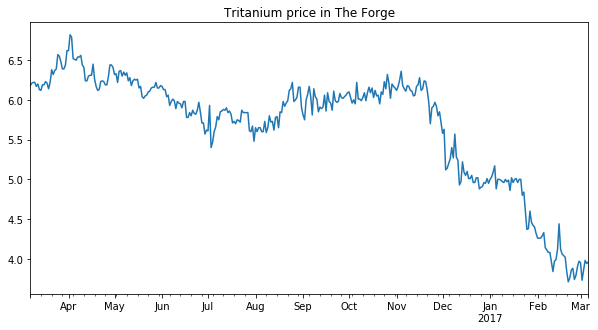

In [39]:
# Step 4 - Graph the average price from the DataFrame.
#
# Finally, we can graph average price for the range we've selected using matplotlib
# If you want to learn more about configuring matplotlib, check out: http://matplotlib.org/
mh_frame.avgPrice.plot(title="Tritanium price in The Forge", figsize=[10,5])